# ShopAssist AI- Top_3_Solar_Panel_Suggestion


#### Project Background

In today's digital age, online shopping has become the go-to option for many consumers. However, the overwhelming number of choices and the lack of personalized assistance can make the shopping experience daunting. To address this, we have developed **ShopAssist AI, a chatbot that combines the power of large language models and rule-based functions to ensure accurate and reliable information delivery**.


#### Problem Statement

*Given a dataset containing information about Solar Panels (product Brand name, Panel Type, Rated Power, Product Description etc.), build a chatbot that parses the dataset and provides accurate solar_panel recommendations based on user requirements*.


Here we can load the data and see it here.

In [1]:
# Install OpenAI library
!pip3 install -U -q openai tenacity

In [ ]:
# Import the libraries
import pandas as pd
from IPython.display import display, HTML
# Set the display width to control the output width
pd.set_option('display.width', 100)
# Read the dataset and read the solar panel Dataset
df = pd.read_csv('solar_panel.csv')
df.head()

Sr.No. Brand Name       Panel Type Rated Power Rated Voltage Actual Price Purchase Price  \
0       1   Luminous        Mono PERC    550 Watt       24 Volt       42,000         16,739   
1       2     Waaree         Bifacial    540 Watt       24 Volt       28,869         12,799   
2       3      Solar  Polycrystalline    335 Watt       24 Volt       16,000         10,899   
3       4     Waaree  Monocrystalline    540 Watt       24 Volt       27,279         12,699   
4       5     Waaree         Bifacial    535 Watt       24 Volt       22,399         12,899   

  Discount  Rating                                Product Description  
0  60% OFF     4.6  The Luminous Solar Panel is a high-quality sol...  
1  55% OFF     4.0  The Waaree Bi-55-540 540W 144 Cells Framed Dua...  
2  31% OFF     4.5  Looking for a top-of-the-line solar panel to p...  
3  53% OFF     4.5  The Waaree 540W 144 Cells Monocrystalline PERC...  
4  42% OFF     4.6  Introducing the Waaree 535Wp 144 Cells Framed ...

In [5]:
df.shape

(60, 10)

#### Approach:

1. **Conversation and Information Gathering**: The chatbot will utilize language models to understand and generate natural responses. Through a conversational flow, it will ask relevant questions to gather information about the user's requirements.
2. **Information Extraction**: Once the essential information is collected, rule-based functions come into play, extracting top *3 Solar Panels* that best matches the user's needs.
3. **Personalized Recommendation**: Leveraging this extracted information, the chatbot engages in further dialogue with the user, efficiently addressing their queries and aiding them in finding the perfect solar panels solution.

## Part 2: System Design


#### Dataset

We have a dataset `solar_panel.csv` where  each row describes the features of a single solar_panel and also has a small description at the end. The chatbot that we build will leverage LLMs to parse this `Description` column and provide recommendations

As you could see in the output above, the chatbot should ask a series of questions to
- Determine the user's requirments. For simplicity, we have used 8 features to encapsulate the user's needs. The 6 features are as follows:

    - Brand Name
    - Panel Type
    - Rated Power
    - Rated Voltage
    - Purchase Price
    - Discount
 
- Confirm if the user's requirements have been correctly captured at the end.

After that the chatbot lists down the top 3 products that are the most relevant, and engages in further conversation to help the user find the best one.


#### Building the Chatbot

Now let's go ahead and understand the system design for the chatbot.

![Chatbot_sys_design.png](https://drive.google.com/uc?id=1j-mw_dNcbxGcelQ0PmkDB0nKOpauU1wX)

|`Stage 1`

- Intent Clarity Layer
- Intent Confirmation Layer

`Stage 2`

- Product Mapping Layer
- Product Information Extraction Layer

`Stage 3`

- Product Recommendation Layer

##### Major functions behind the Chatbot

Let's now look at a brief overview of the major functions that form the chatbot. We'll take a deep dive later



- `initialize_conversation()`: This initializes the variable conversation with the system message.
- `get_chat_completions()`: This takes the ongoing conversation as the input and returns the response by the assistant
- `moderation_check()`: This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, it ends the conversation.
- `intent_confirmation_layer()`: This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not Brand Name, Panel Type, Rated Voltage, Rated Power, Budget, Panel Efficiency, Panel Durability, Installation Ease, Discounts and Energy Output.
- `dictionary_present()`: This function checks if the final understanding of user's profile is returned by the chatbot as a python dictionary or not. If there is a dictionary, it extracts the information as a Python dictionary.
- `compare_solar_panels_with_user()`: This function compares the user's profile with the different solar panel and come back with the top 3 recommendations.
- `initialize_conv_reco()`: Initializes the recommendations conversation

In the next sections, we will look at how to write the code for the above functions.

## Part 3: Implementation

## Stage 1

[Stage 1 Flowchart](https://cdn.upgrad.com/uploads/production/ed8cf454-0c7c-4c5d-bc05-23bb3cea6c57/image+3.jpg)

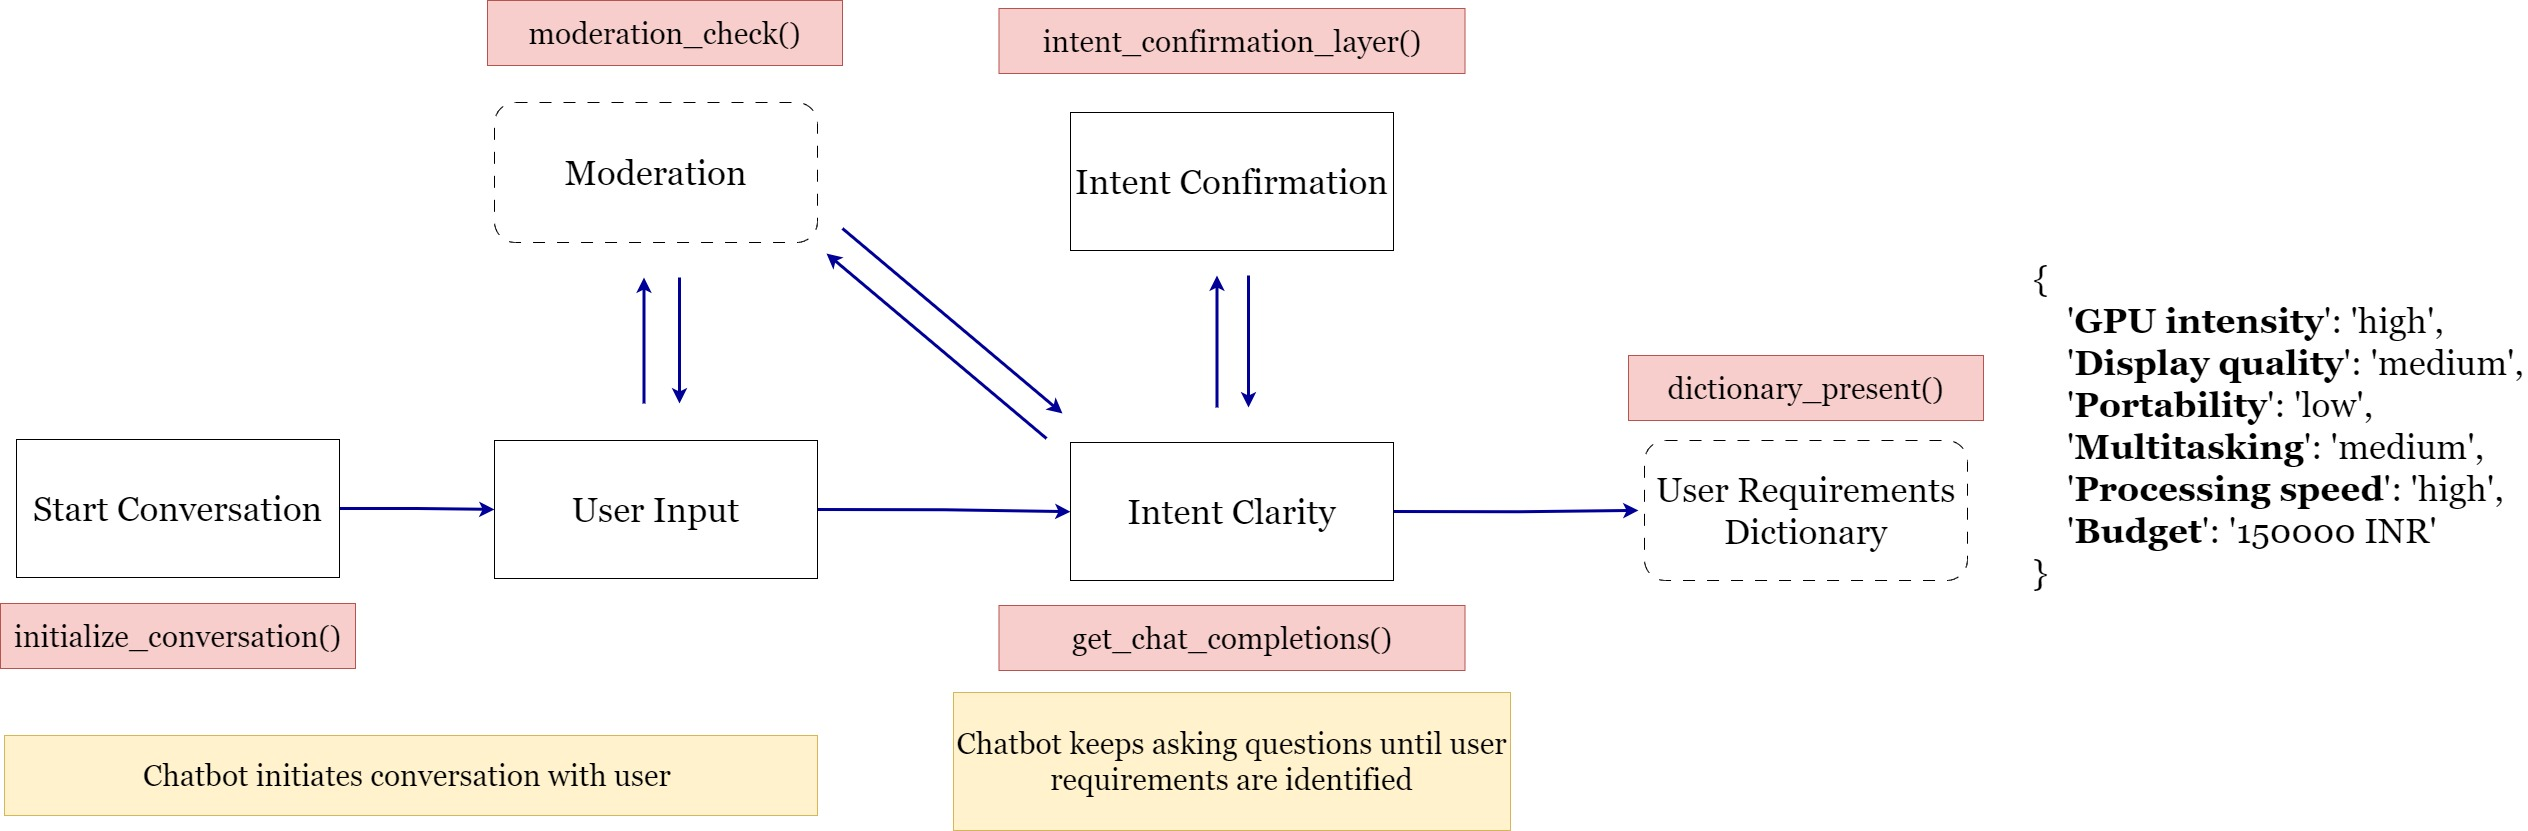

### 3.1 - Import the libraries

Let's start by importing the libraries that we'll require for this project. Following are the ones:
- openai
- pandas
- os, json, ast

Make sure the api key is stored in the text file `OPENAI_API_Key.txt`.

In [6]:
# Import the libraries
import os, json, ast
import openai
from tenacity import retry, wait_random_exponential, stop_after_attempt

In [7]:
# openai.api_key = "Enter Your Open.ai API Key"
openai.api_key = 'Enter Your openai API Key'

### 3.2 - Implementing Intent Clarity and Intent Confirmation Layers

Let's start with the first part of the implementation - building the `intent clarity` and `intent confirmation` layers. As mentioned earlier, this layer helps in identifying the user requirements and passing it on to the product matching layer. Here are the functions that we would be using for building these layers:

- `initialize_conversation()`


### `initialize_conversation()`:
This initializes the variable conversation with the system message. Using prompt engineering and chain of thought reasoning, the function will enable the chatbot to keep asking questions until the user requirements have been captured in a dictionary. It also includes Few Shot Prompting(sample conversation between the user and assistant) to align the model about user and assistant responses at each step.

In [8]:
def initialize_conversation():
    '''
    Returns a list [{"role": "system", "content": system_message}]
    '''

    delimiter = "####"

    example_user_dict = {
        'Brand Name': "Type of brand",
        'Panel Type': "Type of panel",
        'Rated Power': 'High',
        'Rated Voltage': "Low",
        'Purchase Price': "16739",
        'Discount': "min"
    }

    example_user_req = {
        'Brand Name': "_",
        'Panel Type': "_",
        'Rated Power': "_",
        'Rated Voltage': "_",
        'Purchase Price': "_",
        'Discount': "_"
    }

    system_message = f"""
    You are an intelligent solar panel expert and your goal is to find the best solar panel for a user.
    You need to ask relevant questions and understand the user profile by analyzing the user's responses.
    Your final objective is to fill the values for the different keys ('Brand Name', 'Panel Type', 'Rated Power', 'Rated Voltage', 'Purchase Price', 'Discount') in the python dictionary and be confident of the values.
    These key value pairs define the user's profile.
    The python dictionary looks like this
    {{'Brand Name': 'values', 'Panel Type': 'values', 'Rated Power': 'values', 'Rated Voltage': 'values', 'Purchase Price': 'values', 'Discount': 'values'}}
    The value for 'Purchase Price' should be a numerical value extracted from the user's response.
    The values for 'Rated Power' and 'Rated Voltage' should be 'low', 'medium', or 'high' based on the user's requirements.
    All the values in the example dictionary are only representative values.
    {delimiter}
    Here are some instructions around the values for the different keys. If you do not follow this, you'll be heavily penalized:
    - The values for 'Rated Power' and 'Rated Voltage' should strictly be either 'low', 'medium', or 'high' based on the user's requirements.
    - The value for 'Purchase Price' should be a numerical value extracted from the user's response.
    - 'Purchase Price' value needs to be greater than or equal to 559 INR. If the user says less than that, please mention that there are no solar panels in that range.
    - Do not randomly assign values to any of the keys.
    - The values need to be inferred from the user's response.
    {delimiter}

    To fill the dictionary, you need to have the following chain of thoughts:
    Follow the chain-of-thoughts below and only output the final updated python dictionary for the keys as described in {example_user_req}. \n
    {delimiter}
    Thought 1: Ask a question to understand the user's profile and requirements. \n
    If their primary use for the solar panel is unclear. Ask followup questions to understand their needs.
    You are trying to fill the values of all the keys {{'Brand Name', 'Panel Type', 'Rated Power', 'Rated Voltage', 'Purchase Price', 'Discount'}} in the python dictionary by understanding the user requirements.
    Identify the keys for which you can fill the values confidently using the understanding. \n
    Remember the instructions around the values for the different keys.
    If the necessary information has been extracted, only then proceed to the next step. \n
    Otherwise, rephrase the question to capture their profile clearly. \n

    {delimiter}
    Thought 2: Now, you are trying to fill the values for the rest of the keys which you couldn't in the previous step.
    Remember the instructions around the values for the different keys.
    Ask questions you might have for all the keys to strengthen your understanding of the user's profile.
    If yes, move to the next Thought. If no, ask questions on the keys whose values you are unsure of. \n
    It is a good practice to ask questions with a sound logic as opposed to directly citing the key you want to understand the value for.
    {delimiter}

    {delimiter}
    Thought 3: Check if you have correctly updated the values for the different keys in the python dictionary.
    If you are not confident about any of the values, ask clarifying questions.
    {delimiter}

    {delimiter}
    Here is a sample conversation between the user and assistant:
    User: "Hi, I need a solar panel."
    Assistant: "Great! To help you find the best solar panel, could you tell me what brand preferences you have, if any? Also, what type of solar panel are you looking for (monocrystalline, polycrystalline, thin-film)? Understanding these preferences will help me tailor my recommendations. Let me know if my understanding is correct until now."
    User: "I prefer monocrystalline panels."
    Assistant: "Thank you for providing that information. Monocrystalline panels are known for their efficiency. May I know the rated power you are looking for in the panel (e.g., low, medium, high)?"
    User: "I need high-rated power."
    Assistant: "Got it. High-rated power will ensure better performance. Could you also let me know the rated voltage requirement (low, medium, high) and your budget for the solar panel? This will help me find options that fit within your price range while meeting the specified requirements."
    User: "I need high-rated voltage and my budget is around 17000 INR."
    Assistant: "{example_user_dict}"
    {delimiter}

    Start with a short welcome message and encourage the user to share their requirements.
    """
    conversation = [{"role": "system", "content": system_message}]
    return conversation


Let's see what does `initialize_conversation()` does.

<br>

We have added a prefix `debug_` to each of the variables so that we can play around with the inputs and outputs and it doesn't disturb the main function.

In [10]:
debug_conversation = initialize_conversation()
print(debug_conversation)

[{'role': 'system', 'content': '\n    You are an intelligent solar panel expert and your goal is to find the best solar panel for a user.\n    You need to ask relevant questions and understand the user profile by analyzing the user\'s responses.\n    Your final objective is to fill the values for the different keys (\'Brand Name\', \'Panel Type\', \'Rated Power\', \'Rated Voltage\', \'Purchase Price\', \'Discount\') in the python dictionary and be confident of the values.\n    These key value pairs define the user\'s profile.\n    The python dictionary looks like this\n    {\'Brand Name\': \'values\', \'Panel Type\': \'values\', \'Rated Power\': \'values\', \'Rated Voltage\': \'values\', \'Purchase Price\': \'values\', \'Discount\': \'values\'}\n    The value for \'Purchase Price\' should be a numerical value extracted from the user\'s response.\n    The values for \'Rated Power\' and \'Rated Voltage\' should be \'low\', \'medium\', or \'high\' based on the user\'s requirements.\n    A

In [11]:
# Let's look at the content in the debug_conversation key
print(debug_conversation[0]['content'])


    You are an intelligent solar panel expert and your goal is to find the best solar panel for a user.
    You need to ask relevant questions and understand the user profile by analyzing the user's responses.
    Your final objective is to fill the values for the different keys ('Brand Name', 'Panel Type', 'Rated Power', 'Rated Voltage', 'Purchase Price', 'Discount') in the python dictionary and be confident of the values.
    These key value pairs define the user's profile.
    The python dictionary looks like this
    {'Brand Name': 'values', 'Panel Type': 'values', 'Rated Power': 'values', 'Rated Voltage': 'values', 'Purchase Price': 'values', 'Discount': 'values'}
    The value for 'Purchase Price' should be a numerical value extracted from the user's response.
    The values for 'Rated Power' and 'Rated Voltage' should be 'low', 'medium', or 'high' based on the user's requirements.
    All the values in the example dictionary are only representative values.
    ####
    Here are

In [12]:
# Let's initialise conversation
system_message = initialize_conversation()
print(system_message[0]["content"])


    You are an intelligent solar panel expert and your goal is to find the best solar panel for a user.
    You need to ask relevant questions and understand the user profile by analyzing the user's responses.
    Your final objective is to fill the values for the different keys ('Brand Name', 'Panel Type', 'Rated Power', 'Rated Voltage', 'Purchase Price', 'Discount') in the python dictionary and be confident of the values.
    These key value pairs define the user's profile.
    The python dictionary looks like this
    {'Brand Name': 'values', 'Panel Type': 'values', 'Rated Power': 'values', 'Rated Voltage': 'values', 'Purchase Price': 'values', 'Discount': 'values'}
    The value for 'Purchase Price' should be a numerical value extracted from the user's response.
    The values for 'Rated Power' and 'Rated Voltage' should be 'low', 'medium', or 'high' based on the user's requirements.
    All the values in the example dictionary are only representative values.
    ####
    Here are

Let's now look at the next function.
- `get_chat_completions()`: This takes the ongoing conversation as the input and returns the response by the assistant. We'll use the Chat Completions function for performing LLM calls to OpenAI.

### `get_chat_completions()`:

This function perform LLM call using the Chat Completions API to get the LLM response.

In [13]:
# Define a Chat Completions API call
# Retry up to 6 times with exponential backoff, starting at 1 second and maxing out at 20 seconds delay
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_chat_completions(input, json_format = False):
    MODEL = 'gpt-3.5-turbo'

    system_message_json_output = """<<. Return output in JSON format to the key output.>>"""

    # If the output is required to be in JSON format
    if json_format == True:
        # Append the input prompt to include JSON response as specified by OpenAI
        input[0]['content'] += system_message_json_output

        # JSON return type specified
        chat_completion_json = openai.chat.completions.create(
            model = MODEL,
            messages = input,
            response_format = { "type": "json_object"},
            seed = 1234)

        output = json.loads(chat_completion_json.choices[0].message.content)

    # No JSON return type specified
    else:
        chat_completion = openai.chat.completions.create(
            model = MODEL,
            messages = input,
            seed = 2345)

        output = chat_completion.choices[0].message.content

    return output

In [15]:
# Testing the OpenAI functions defined above
input_prompt ='how many months in a year?'
messages = [{'role':'user','content':input_prompt}]
# system_message_json_output = """<<. Return output in JSON format.>>"""
# messages[0]['content']+=system_message_json_output
messages

[{'role': 'user', 'content': 'how many months in a year?'}]

In [16]:
## Get LLM Outputs - normal
get_chat_completions(messages) ## Chat Completions API

'There are twelve months in a year.'

In [17]:
## Get LLM Outputs - JSON output
get_chat_completions(messages, json_format = True) ## Chat Completions API and return in JSON format

{'output': 12}

### iterate_response() - Helper Function:
We've created a small helper test function to ensure the model's response is consistent.
Uncomment the code blocks and run the function `iterate_response(response)` to check if the response of the `intent_confirmation_layer`is consistent.}

In [18]:
def iterate_llm_response(funct, debug_response, num = 10):
    """
    Calls a specified function repeatedly and prints the results.
    This function is designed to test the consistency of a response from a given function.
    It calls the function multiple times (default is 10) and prints out the iteration count,
    the function's response(s).
    Args:
        funct (function): The function to be tested. This function should accept a single argument
                          and return the response value(s).
        debug_response (dict): The input argument to be passed to 'funct' on each call.
        num (int, optional): The number of times 'funct' will be called. Defaults to 10.
    Returns:
        This function only returns the results to the console.
    """
    i = 0  # Initialize counter

    while i < num:  # Loop to call the function 'num' times

        response = funct(debug_response)  # Call the function with the debug response

        # Print the iteration number, result, and reason from the response
        print("Iteration: {0}".format(i))
        print(response)
        print('-' * 50)  # Print a separator line for readability
        i += 1  # Increment the counter

# Example usage: test the consistency of responses from 'intent_confirmation_layer'
iterate_llm_response(get_chat_completions, messages)

Iteration: 0
{
    "output": 12
}
--------------------------------------------------
Iteration: 1
{
    "output": 12
}
--------------------------------------------------
Iteration: 2
{
    "output": 12
}
--------------------------------------------------
Iteration: 3
{
    "output": 12
}
--------------------------------------------------
Iteration: 4
{
    "output": 12
}
--------------------------------------------------
Iteration: 5
{
    "output": 12
}
--------------------------------------------------
Iteration: 6
{
    "output": 12
}
--------------------------------------------------
Iteration: 7
{
    "output": 12
}
--------------------------------------------------
Iteration: 8
{
    "output": 12
}
--------------------------------------------------
Iteration: 9
{
    "output": 12
}
--------------------------------------------------


Let's pass the initialized conversation `debug_conversation` and see what is the assistant's response.

In [19]:
debug_user_input = "Hi, I am Yogesh, I need a solar panel for power generation at my home."

In [20]:
debug_conversation.append({"role": "user", "content": debug_user_input})
# print(debug_conversation[0]["content"]) # System Message
print(debug_conversation[1]["content"]) # User Input

Hi, I am Yogesh, I need a solar panel for power generation at my home.


In [21]:
# Let's look at the debug_conversation list
display(debug_conversation)

[{'role': 'system',
  'content': '\n    You are an intelligent solar panel expert and your goal is to find the best solar panel for a user.\n    You need to ask relevant questions and understand the user profile by analyzing the user\'s responses.\n    Your final objective is to fill the values for the different keys (\'Brand Name\', \'Panel Type\', \'Rated Power\', \'Rated Voltage\', \'Purchase Price\', \'Discount\') in the python dictionary and be confident of the values.\n    These key value pairs define the user\'s profile.\n    The python dictionary looks like this\n    {\'Brand Name\': \'values\', \'Panel Type\': \'values\', \'Rated Power\': \'values\', \'Rated Voltage\': \'values\', \'Purchase Price\': \'values\', \'Discount\': \'values\'}\n    The value for \'Purchase Price\' should be a numerical value extracted from the user\'s response.\n    The values for \'Rated Power\' and \'Rated Voltage\' should be \'low\', \'medium\', or \'high\' based on the user\'s requirements.\n   

In [22]:
# Getting the response from the Assistant by passing the conversation to the Chat Completions API
debug_response_assistant = get_chat_completions(debug_conversation)
display(debug_response_assistant)

'Great to hear that you are looking for a solar panel for power generation at home, Yogesh. To assist you better in finding the best solar panel, could you please share your brand preferences, if any? Additionally, do you have a specific type of solar panel in mind (e.g., monocrystalline, polycrystalline, thin-film)? Understanding these preferences will help me tailor my recommendations.'

Let's play around a bit and add the following user's input `debug_user_input` to the conversation `debug_conversation` and see what the assistant responds with.

In [23]:
# Let's append this to the conversation list
debug_conversation.append(({"role": "system", "content": debug_response_assistant}))
debug_conversation

[{'role': 'system',
  'content': '\n    You are an intelligent solar panel expert and your goal is to find the best solar panel for a user.\n    You need to ask relevant questions and understand the user profile by analyzing the user\'s responses.\n    Your final objective is to fill the values for the different keys (\'Brand Name\', \'Panel Type\', \'Rated Power\', \'Rated Voltage\', \'Purchase Price\', \'Discount\') in the python dictionary and be confident of the values.\n    These key value pairs define the user\'s profile.\n    The python dictionary looks like this\n    {\'Brand Name\': \'values\', \'Panel Type\': \'values\', \'Rated Power\': \'values\', \'Rated Voltage\': \'values\', \'Purchase Price\': \'values\', \'Discount\': \'values\'}\n    The value for \'Purchase Price\' should be a numerical value extracted from the user\'s response.\n    The values for \'Rated Power\' and \'Rated Voltage\' should be \'low\', \'medium\', or \'high\' based on the user\'s requirements.\n   

Typically, whenever the chatbot is interacting with the user, all the conversations should be moderated to identify any inappropriate content. Let's look at the function that can help with it.

### `moderation_check()`:
 This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, you can add a break statement to end the conversation.

In [24]:
# Define a function called moderation_check that takes user_input as a parameter.

def moderation_check(user_input):
    # Call the OpenAI API to perform moderation on the user's input.
    response = openai.moderations.create(input=user_input)

    # Extract the moderation result from the API response.
    moderation_output = response.results[0].flagged
    # Check if the input was flagged by the moderation system.
    if response.results[0].flagged == True:
        # If flagged, return "Flagged"
        return "Flagged"
    else:
        # If not flagged, return "Not Flagged"
        return "Not Flagged"

In [25]:
moderation_check("I want to kill them.")

'Flagged'

Let's test moderation on the `debug_user_input`

In [26]:
debug_moderation = moderation_check(debug_user_input)
print(debug_moderation)

Not Flagged


Let's now test moderation on some other text.

In [27]:
print(moderation_check("how can I hack someone llm model."))
print(moderation_check("i want to kill pooja."))
print(moderation_check("I need a solar panel"))

Not Flagged
Flagged
Not Flagged


So, this moderation api may not be perfect but if you ask this to the ChatGPT or it's API (GPT 3.5), it'll not help you with such requests. Remember, moderation should also be applied on the GPT 3.5's output.

Let's now check moderation on the assistant's response `debug_response_assistant`.

In [28]:
moderation_check(debug_response_assistant)

'Not Flagged'

As mentioned earlier, you need to understand the user's profile, which essentially means that all the features: 'Brand Name', 'Panel Type', 'Rated Power', 'Rated Voltage' 'Budget' and 'Discount' are captured or not. Let's look at the function that helps us verify that.

### `intent_confirmation_layer()`:

This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not
    - Brand Name
    - Panel Type
    - Rated Power
    - Rated Voltage
    - Purchase Price
    - Discount

In [29]:
import json
import openai

def intent_confirmation_layer(response_assistant):
    """
    Evaluates if the input text has the required keys with correctly filled values.
    """

    delimiter = "####"

    allowed_brands = {'Waaree', 'Luminous', 'UTL', 'SUI', 'Solar', 'Vikram Solar', 'Tata Power'}

    allowed_panel_types = {
        "Bifacial",
        "Half Cut Mono Bifacial",
        "Mono Bifacial",
        "Mono PERC",
        "Mono PERC Bifacial",
        "Monocrystalline",
        "Polycrystalline"
    }

    allowed_rated_power = {'low', 'medium', 'high'}
    allowed_rated_voltage = {'low', 'medium', 'high'}
    allowed_discount = {'min', 'max'}

    prompt = f"""
    You are a senior evaluator who has an eye for detail. The input text will contain a user requirement captured through 6 keys.
    You are provided an input. You need to evaluate if the input text has the following keys:
    {{
    'Brand Name': 'values',
    'Panel Type': 'values',
    'Rated Power': 'values',
    'Rated Voltage': 'values',
    'Purchase Price': 'number',
    'Discount': 'values'
    }}
    The values for 'Brand Name' should only be from the allowed values: {allowed_brands}.
    The values for 'Panel Type' should only be from the allowed values: {allowed_panel_types}.
    The 'Rated Power' should be one of the allowed values: {allowed_rated_power}.
    The 'Rated Voltage' should be one of the allowed values: {allowed_rated_voltage}.
    The 'Purchase Price' should be a numerical value.
    The 'Discount' should be one of the allowed values: {allowed_discount}.
    Next, you need to evaluate if the keys have the values filled correctly.
    Only output a one-word string in JSON format at the key 'result' - Yes/No.
    Thought 1 - Output a string 'Yes' if the values are correctly filled for all keys, otherwise output 'No'.
    Thought 2 - If the answer is No, mention the reason in the key 'reason'.
    Thought 3 - Think carefully before answering.
    """

    messages = [{"role": "system", "content": prompt},
                {"role": "user", "content": f"Here is the input: {response_assistant}"}]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    # json_output = json.loads(response.choices[0].message['content'])
    json_output = json.loads(response.choices[0].message.to_dict()['content'])
    return json_output


Let's apply the function to the assistant's reponse and see if it has captured the user profile.

In [31]:
debug_response_assistant

'Great to hear that you are looking for a solar panel for power generation at home, Yogesh. To assist you better in finding the best solar panel, could you please share your brand preferences, if any? Additionally, do you have a specific type of solar panel in mind (e.g., monocrystalline, polycrystalline, thin-film)? Understanding these preferences will help me tailor my recommendations.'

In [32]:
debug_confirmation = intent_confirmation_layer(debug_response_assistant)
display(debug_confirmation)

{'result': 'No', 'reason': 'Missing key information'}

In [33]:
# Printing the value for better clarity
print("Result:",debug_confirmation.get('result'),"\t", "Reason:", debug_confirmation.get('reason'))

Result: No 	 Reason: Missing key information


Now, you can keep adding user and assistant responses to debug_conversation and get to a point where intent_confirmation_layer() gives yes as a response. Let's see if the following response by the assistant passes the intent_confirmation_layer() test.

In [34]:
#Let's add the above assistant response to the debug_conversation.
debug_conversation.append({"role": "assistant", "content": debug_response_assistant})

In [35]:
debug_conversation

[{'role': 'system',
  'content': '\n    You are an intelligent solar panel expert and your goal is to find the best solar panel for a user.\n    You need to ask relevant questions and understand the user profile by analyzing the user\'s responses.\n    Your final objective is to fill the values for the different keys (\'Brand Name\', \'Panel Type\', \'Rated Power\', \'Rated Voltage\', \'Purchase Price\', \'Discount\') in the python dictionary and be confident of the values.\n    These key value pairs define the user\'s profile.\n    The python dictionary looks like this\n    {\'Brand Name\': \'values\', \'Panel Type\': \'values\', \'Rated Power\': \'values\', \'Rated Voltage\': \'values\', \'Purchase Price\': \'values\', \'Discount\': \'values\'}\n    The value for \'Purchase Price\' should be a numerical value extracted from the user\'s response.\n    The values for \'Rated Power\' and \'Rated Voltage\' should be \'low\', \'medium\', or \'high\' based on the user\'s requirements.\n   

Let's say that after a series of conversations you get the following response from the assistant.

In [36]:
# Example 1 - Let's check with the confirmation_layer if all the keys are present for solar panels
debug_response_assistant_1 = f"""
Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the solar panel you are looking for:
{{
    'Brand Name': 'Waaree',
    'Panel Type': 'Bifacial',
    'Rated Power': 'high',
    'Rated Voltage': 'low',
    'Purchase Price': '12799',
    'Discount': 'max'
}}
"""
# Note that you are using double curly braces

print(debug_response_assistant_1)



Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the solar panel you are looking for:
{
    'Brand Name': 'Waaree',
    'Panel Type': 'Bifacial',
    'Rated Power': 'high',
    'Rated Voltage': 'low',
    'Purchase Price': '12799',
    'Discount': 'max'
}



Do you think it'll pass the `intent_confirmation_layer()` test?

 Let's try it out.

In [37]:
response = intent_confirmation_layer(debug_response_assistant_1)
response.get('result') # Extract the result key from the dictionary

'Yes'

In [38]:
# Example 1 - Let's check with the confirmation_layer if all the keys are present for solar panels
debug_response_assistant_2 = f"""
Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the solar panel you are looking for:
{{
    'Brand Name': 'Luminous',
    'Panel Type': 'Polycrystalline',
    'Rated Voltage': 'low',
    'Purchase Price': '12639',
    'Discount': 'max'
}}
"""
# Note that you are using double curly braces

print(debug_response_assistant_2)

#miss Rated Power : 170 watt



Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the solar panel you are looking for:
{
    'Brand Name': 'Luminous',
    'Panel Type': 'Polycrystalline',
    'Rated Voltage': 'low',
    'Purchase Price': '12639',
    'Discount': 'max'
}



In [39]:
intent_confirmation_layer(debug_response_assistant_2)
# iterate_llm_response(intent_confirmation_layer, debug_response_assistant_2)

{'result': 'Yes'}

In [40]:
# Example 1 - Let's check with the confirmation_layer if all the keys are present for solar panels
debug_response_assistant_3 = f"""
Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the solar panel you are looking for:
{{
    'Brand Name': 'SUI',
    'Panel Type': 'Polycrystalline',
    'Rated Power': 'high',
    'Discount': 'min'
}}
"""
# Note that you are using double curly braces

print(debug_response_assistant_3)
#miss Rated Volatge : 24 watt



Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the solar panel you are looking for:
{
    'Brand Name': 'SUI',
    'Panel Type': 'Polycrystalline',
    'Rated Power': 'high',
    'Discount': 'min'
}



In [41]:
intent_confirmation_layer(debug_response_assistant_3)
# iterate_llm_response(intent_confirmation_layer, debug_response_assistant_2)

{'result': 'Yes'}

Let's now look at the working of `dictionary_present()`.

### `dictionary_present()`:

This function checks if the final understanding of user's profile is returned by the chatbot is a Python dictionary or not. This is important as it'll be used later on for finding the right solar panels using dictionary matching.

In [42]:
def dictionary_present(response):
    delimiter = "####"

    allowed_brands = {'Waaree', 'Luminous', 'UTL', 'SUI', 'Solar', 'Vikram Solar', 'Tata Power'}
    allowed_panel_types = {
        "Bifacial",
        "Half Cut Mono Bifacial",
        "Mono Bifacial",
        "Mono PERC",
        "Mono PERC Bifacial",
        "Monocrystalline",
        "Polycrystalline"
    }
    allowed_rated_power = {'low', 'medium', 'high'}
    allowed_rated_voltage = {'low', 'medium', 'high'}
    allowed_discount = {'min', 'max'}

    solar_panel_req = {
        'Brand Name': 'values',
        'Panel Type': 'values',
        'Rated Power': 'high',
        'Rated Voltage': 'low',
        'Purchase Price': 'numerical value',
        'Discount': 'min'
    }

    prompt = f"""You are a solar panel expert. You are provided an input.
            You have to check if there is relevant information present in the string for solar panel specifications.
            It should contain the following keys: {solar_panel_req}.
            Your task is to extract the relevant values from the input and return them in JSON format.
            The output should match the format as {solar_panel_req}.

            {delimiter}
            Make sure that all the necessary keys and their values are present in the input.
            Ensure the keys and values are in the given format:
            {{
            'Brand Name': 'values',
            'Panel Type': 'values',
            'Rated Power': 'low/medium/high',
            'Rated Voltage': 'low/medium/high',
            'Purchase Price': 'numerical value',
            'Discount': 'min/max'
            }}
            The values for 'Brand Name' should only be from the allowed values: {allowed_brands}.
            The values for 'Panel Type' should only be from the allowed values: {allowed_panel_types}.
            The 'Rated Power' should be one of the allowed values: {allowed_rated_power}.
            The 'Rated Voltage' should be one of the allowed values: {allowed_rated_voltage}.
            The 'Purchase Price' should be a numerical value.
            The 'Discount' should be one of the allowed values: {allowed_discount}.

            Here are some sample input output pairs for better understanding:
            {delimiter}
            input 1: - Brand Name: Waaree - Panel Type: Mono PERC - Rated Power: high - Rated Voltage: medium - Purchase Price: 16739 INR - Discount: min
            output 1: {{'Brand Name': 'Waaree', 'Panel Type': 'Mono PERC', 'Rated Power': 'high', 'Rated Voltage': 'medium', 'Purchase Price': 16739, 'Discount': 'min'}}

            input 2: {{'Brand Name': 'Vikram Solar', 'Panel Type': 'Monocrystalline', 'Rated Power': medium, 'Rated Voltage': high, 'Purchase Price': 18399 INR, 'Discount': max}}
            output 2: {{'Brand Name': 'Vikram Solar', 'Panel Type': 'Monocrystalline', 'Rated Power': 'medium', 'Rated Voltage': 'high', 'Purchase Price': 18399, 'Discount': 'max'}}

            input 3: Solar Panel Details: 'Brand Name': 'UTL', 'Panel Type': 'Polycrystalline', 'Rated Power': low, 'Rated Voltage': low, 'Purchase Price': 6099 INR, 'Discount': min
            output 3: {{'Brand Name': 'UTL', 'Panel Type': 'Polycrystalline', 'Rated Power': 'low', 'Rated Voltage': 'low', 'Purchase Price': 6099, 'Discount': 'min'}}
            {delimiter}
            """
    messages = [{"role": "system", "content": prompt},
                {"role": "user", "content": f"""Here is the input: {response}"""}]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    # json_output = json.loads(response.choices[0].message['content'])

    # return json_output

    confirmation = get_chat_completions(messages, json_format = True)

    return confirmation


Let's start by passing the `debug_response_assistant`.

In [44]:
debug_response_assistant_n = """
{'Brand Name': 'Luminous',
 'Panel Type': 'Mono PERC',
 'Rated Power': 'medium',
 'Rated Voltage': 'low',
 'Purchase Price': '50000',
 'Discount': 'max'}
"""

In [45]:
response_dict_n = dictionary_present(debug_response_assistant_n)
display(response_dict_n)

{'Brand Name': 'Luminous',
 'Panel Type': 'Mono PERC',
 'Rated Power': 'medium',
 'Rated Voltage': 'low',
 'Purchase Price': 50000,
 'Discount': 'max'}

In [46]:
type(response_dict_n)

dict

What if you pass something like this where it is not in the form of a dictionary? Or some key or some values are missing? Let's see.

In [47]:
debug_response_assistant_n = f"""Thank you for providing your budget.
Based on your budget of 50,000 INR, I will consider this while recommending suitable solar panel options for you.
Here is the final recommendation for your solar panel:

-Brand Name': Solar,
-Panel Type': Monocrystalline,
-Rated Power': 'medium,
-Rated Voltage':'medium,
-Purchase Price': '15099 INR',
-Discount': 'min'

Please note that these specifications are based on your requirements for a high-efficiency, durable solar panel within your budget.
Let me know if there's anything else I can assist you with!"""


In [48]:
response_dict_n = dictionary_present(debug_response_assistant_n)
display(response_dict_n)

{'Brand Name': 'Solar',
 'Panel Type': 'Monocrystalline',
 'Rated Power': 'medium',
 'Rated Voltage': 'medium',
 'Purchase Price': 15099,
 'Discount': 'min'}

In [49]:
type(response_dict_n)

dict

In [50]:
# Check for LLM function's consistency
iterate_llm_response(dictionary_present, debug_response_assistant_n)

Iteration: 0
{'Brand Name': 'Solar', 'Panel Type': 'Monocrystalline', 'Rated Power': 'medium', 'Rated Voltage': 'medium', 'Purchase Price': 15099, 'Discount': 'min'}
--------------------------------------------------
Iteration: 1
{'Brand Name': 'Solar', 'Panel Type': 'Monocrystalline', 'Rated Power': 'medium', 'Rated Voltage': 'medium', 'Purchase Price': 15099, 'Discount': 'min'}
--------------------------------------------------
Iteration: 2
{'Brand Name': 'Solar', 'Panel Type': 'Monocrystalline', 'Rated Power': 'medium', 'Rated Voltage': 'medium', 'Purchase Price': 15099, 'Discount': 'min'}
--------------------------------------------------
Iteration: 3
{'Brand Name': 'Solar', 'Panel Type': 'Monocrystalline', 'Rated Power': 'medium', 'Rated Voltage': 'medium', 'Purchase Price': 15099, 'Discount': 'min'}
--------------------------------------------------
Iteration: 4
{'Brand Name': 'Solar', 'Panel Type': 'Monocrystalline', 'Rated Power': 'medium', 'Rated Voltage': 'medium', 'Purchase 

Let's quickly take a look at the code that we have run until now.

In [51]:
debug_conversation

[{'role': 'system',
  'content': '\n    You are an intelligent solar panel expert and your goal is to find the best solar panel for a user.\n    You need to ask relevant questions and understand the user profile by analyzing the user\'s responses.\n    Your final objective is to fill the values for the different keys (\'Brand Name\', \'Panel Type\', \'Rated Power\', \'Rated Voltage\', \'Purchase Price\', \'Discount\') in the python dictionary and be confident of the values.\n    These key value pairs define the user\'s profile.\n    The python dictionary looks like this\n    {\'Brand Name\': \'values\', \'Panel Type\': \'values\', \'Rated Power\': \'values\', \'Rated Voltage\': \'values\', \'Purchase Price\': \'values\', \'Discount\': \'values\'}\n    The value for \'Purchase Price\' should be a numerical value extracted from the user\'s response.\n    The values for \'Rated Power\' and \'Rated Voltage\' should be \'low\', \'medium\', or \'high\' based on the user\'s requirements.\n   

In [52]:
debug_conversation = initialize_conversation()
debug_user_input = "Hi, I am Yogesh, I need a solar panel for power generation at my home."
debug_moderation = moderation_check(debug_user_input)
debug_conversation.append({"role": "user", "content": debug_user_input})
debug_response_assistant = get_chat_completions(debug_conversation)
debug_moderation = moderation_check(debug_response_assistant)
debug_conversation.append({"role": "assistant", "content": debug_response_assistant})
debug_confirmation = intent_confirmation_layer(debug_response_assistant)
# After a series of conversation...
response_dict_n = dictionary_present(debug_response_assistant_n)
print(response_dict_n)

{'Brand Name': 'Solar', 'Panel Type': 'Monocrystalline', 'Rated Power': 'medium', 'Rated Voltage': 'medium', 'Purchase Price': 15099, 'Discount': 'min'}


So, now that you have the user profile stored in `response_dict_n`. We'll use this to generate recommendations. Before that, we need to create a similar profile for every solar panel. Let's see how we do it.

## Stage 2

[Stage 2 Flowchart](https://cdn.upgrad.com/uploads/production/c71aa254-32db-4265-a083-f4a540dac014/Stage+2.jpg)

### 3.3 Implementing the Product Mapping and Information Extraction Layers

In this section, we take in the output of the previous layers, i.e. the user requirements, which is in the format of a Python dictionary.
<br>
Next we will extract the top 3 Solar Panels recommendations based on user's requirements.

This stage consists of the following helper functions that will implement the information extraction and product matching layers.

### `product_map_layer()`:

This function is responsible for extracting key features and criteria from solar panel descriptions. Here's a breakdown of how it works:

-  Use a prompt that assign it the role of a solar panels product descriprion classifier, whose objective is to extract key features and classify them based on solar panels descriptions.

- Provide step-by-step instructions for extracting solar panels features from description.

- Assign specific rules for each feature (e.g. 'Brand Name', 'Panel Type', 'Rated Power', 'Rated Voltage', 'Purchase Price' and 'Discount') and associate them with the appropriate classification value (Low, Medium, or High) and (min and max)

- Includes Few Shot Prompting (sample conversation between the user and assistant) to demonstrate the expected result of the feature extraction and classification process.

In [53]:

def product_map_layer(solar_panel_description):
    delimiter = "#####"

    panel_spec = {
        "Brand Name": "Luminous",
        "Panel Type": "Mono PERC Halfcu",
        "Rated Power": "(Depend on Rated Power)",
        "Rated Voltage": "(Depend on Rated Voltage)",
        "Purchase Price": "20000",
        "Discount": "(Depend on discount)"
    }
    allowen_brand_name = {'Waaree', 'Luminous', 'UTL', 'SUI', 'Solar', 'Vikram Solar', 'Tata Power'}
    allowed_panel_types = {
        "Bifacial",
        "Half Cut Mono Bifacial",
        "Mono Bifacial",
        "Mono PERC",
        "Mono PERC Bifacial",
        "Monocrystalline",
        "Polycrystalline"
    }
    allowed_rated_power = {'low', 'medium', 'high'}
    allowed_rated_voltage = {'low', 'medium', 'high'}
    allowed_discount = {'min', 'max'}

    prompt = f"""
    You are a Solar Panel Specifications Classifier tasked with extracting key features of solar panels and classifying them based on their quality.
    To analyze each solar panel, follow these steps:
    Step 1: Extract the primary features from the product description.
    Step 2: Store the extracted features in a dictionary similar to the following format:
    {panel_spec}
    Step 3: Classify each item in the dictionary based on the rules below.

    {delimiter}
    Classification Rules:
    Rated Power:
    - low: if rated power is less than 300 W
    - medium: if rated power is between 300 W and 500 W
    - high: if rated power is greater than 500 W

    Rated Voltage:
    - low: if rated voltage is less than 30 V
    - medium: if rated voltage is between 30 V and 50 V
    - high: if rated voltage is greater than 50 V

    Discount:
    - min: if discount is less than 20%
    - max: if discount is greater than 20%

    {delimiter}
    Here is an input-output pair for better understanding:
    {delimiter}
    input 1: "The Luminous Mono PERC Halfcut Solar Panel is a high-quality solar panel known for its efficiency and durability. It offers a rated power of 550 W and operates at a rated voltage of 24 V. With its advanced technology, it provides excellent performance in converting sunlight into electricity. This solar panel is suitable for both residential and commercial applications, making it a versatile choice for solar energy solutions."
    output 1: {{'Brand Name': 'Luminous', 'Panel Type': 'Mono PERC Halfcut', 'Rated Power': 'high', 'Rated Voltage': 'low', 'Purchase Price': '20000', 'Discount': 'min'}}
    {delimiter}

    Ensure the extracted features match the classification rules and format them correctly.
    """

    input_message = f"""Follow the instructions above step-by-step and output the dictionary in JSON format for the following solar panel: {solar_panel_description}."""
    messages = [{"role": "system", "content": prompt}, {"role": "user", "content": input_message}]

    response = get_chat_completions(messages, json_format=True)

    return response


Let's test this for one sample solar panel description.

In [55]:
solar_panel_description_1 = f"""
The Luminous Solar Panel is a high-quality solar panel that is designed to provide efficient and reliable power generation.
With a voltage of 24 V and a rated power of 550 W, this solar panel is perfect for a variety of applications. The panel type is Mono PERC,
which ensures maximum power output and durability. With a rated power range of 401-800 W, the Luminous Solar Panel is suitable for both residential and commercial use.
The short circuit current (isc) is 13.98 Amp, while the current at max power (imp) is 13.2 Amp. This means that the panel can generate a significant amount of power even under low light conditions.
The open circuit voltage (voc) is 49.80 V, which ensures that the panel can start generating power quickly and efficiently.
The Luminous Solar Panel is also designed to withstand harsh weather conditions, making it a reliable and durable choice for any solar power system.
Shop Luminous 550W 24V Mono PERC Halfcut Solar Panel at discounted prices online in India.
If you have been seeking for Luminous 550W 24V Mono PERC Halfcut Solar Panel dealers, that search is over here.
You can buy Luminous 550W 24V Mono PERC Halfcut Solar Panel of the highest caliber and be confident that you will receive the best in terms of efficiency and durability.
If the Luminous 550W 24V Mono PERC Halfcut Solar Panel rates are a concern for you, be confident that Moglix will provide the best prices.
We offer genuine Luminous 550W 24V Mono PERC Halfcut Solar Panel pricing and the highest quality that is unmatched by others.
Buy Luminous 550W 24V Mono PERC Halfcut Solar Panel today and avail the best deal on your shopping.
Browse through the extensive list of  Solar Panels at Moglix. Shop online for other Luminous Solar Panels. available at Moglix in the lowest price range.
"""

In [56]:
display(product_map_layer(solar_panel_description_1))

{'Brand Name': 'Luminous',
 'Panel Type': 'Mono PERC Halfcut',
 'Rated Power': 'high',
 'Rated Voltage': 'medium',
 'Purchase Price': 'Depend on discount',
 'Discount': 'max'}

In [57]:
# # Data type of the output response
print(type(product_map_layer(solar_panel_description_1)))

<class 'dict'>


In [58]:
# # Check for consistency with iterate_response function
iterate_llm_response(product_map_layer, solar_panel_description_1)

Iteration: 0
{'Brand Name': 'Luminous', 'Panel Type': 'Mono PERC Halfcut', 'Rated Power': 'high', 'Rated Voltage': 'medium', 'Purchase Price': 'Depend on discount', 'Discount': 'max'}
--------------------------------------------------
Iteration: 1
{'Brand Name': 'Luminous', 'Panel Type': 'Mono PERC Halfcut', 'Rated Power': 'high', 'Rated Voltage': 'medium', 'Purchase Price': 'Depend on discount', 'Discount': 'max'}
--------------------------------------------------
Iteration: 2
{'Brand Name': 'Luminous', 'Panel Type': 'Mono PERC Halfcut', 'Rated Power': 'high', 'Rated Voltage': 'medium', 'Purchase Price': 'Depend on discount', 'Discount': 'max'}
--------------------------------------------------
Iteration: 3
{'Brand Name': 'Luminous', 'Panel Type': 'Mono PERC Halfcut', 'Rated Power': 'high', 'Rated Voltage': 'medium', 'Purchase Price': 'Depend on discount', 'Discount': 'max'}
--------------------------------------------------
Iteration: 4
{'Brand Name': 'Luminous', 'Panel Type': 'Mono 

Let's now apply this function to the entire solar panel dataset

In [ ]:
##Run this code once to extract product info in the form of a dictionary
solar_df= pd.read_csv('solar_panel.csv')

## Create a new column "solar_feature" that contains the dictionary of the product features
solar_df['Solar Feature'] = solar_df['Product Description'].apply(lambda x: product_map_layer(x))

In [60]:
solar_df.to_csv("updated_solar_panel.csv",index=False,header = True)

In [61]:
solar_df.head()

Sr.No. Brand Name       Panel Type Rated Power Rated Voltage Actual Price Purchase Price  \
0       1   Luminous        Mono PERC    550 Watt       24 Volt       42,000         16,739   
1       2     Waaree         Bifacial    540 Watt       24 Volt       28,869         12,799   
2       3      Solar  Polycrystalline    335 Watt       24 Volt       16,000         10,899   
3       4     Waaree  Monocrystalline    540 Watt       24 Volt       27,279         12,699   
4       5     Waaree         Bifacial    535 Watt       24 Volt       22,399         12,899   

  Discount  Rating                                Product Description  \
0  60% OFF     4.6  The Luminous Solar Panel is a high-quality sol...   
1  55% OFF     4.0  The Waaree Bi-55-540 540W 144 Cells Framed Dua...   
2  31% OFF     4.5  Looking for a top-of-the-line solar panel to p...   
3  53% OFF     4.5  The Waaree 540W 144 Cells Monocrystalline PERC...   
4  42% OFF     4.6  Introducing the Waaree 535Wp 144 Cells Framed ...   

                                       Solar Feature  
0  {'Brand Name': 'Luminous', 'Panel Type': 'Mono...  
1  {'Brand Name': 'Waaree', 'Panel Type': 'Mono P...  
2  {'Brand Name': 'Solar Universe', 'Panel Type':...  
3  {'Brand Name': 'Waaree', 'Panel Type': '540W 1...  
4  {'Brand Name': 'Waaree', 'Panel Type': 'Dual G...

In [62]:
solar_df.shape

(60, 11)

### `compare_solar_panels_with_user()`:

This function compares the user's profile with the different solar panels and come back with the top  recommendations. It will perform the following steps:
    - It will take the user requirements dictionary as input
    - Filter the solar panels based on their price, keeping only the ones within the user's budget.
    - Calculate a score for each solar panel based on how well it matches the user's requirements.
    - Sort the solar panels based on their scores in descending order.
    - Return the top 3 solar panels as a JSON-formatted string.

In [ ]:
import pandas as pd  # Importing the pandas library for data manipulation
import json


def compare_solar_panel_with_user(user_req_string):
    solar_panels_df = pd.read_csv('updated_solar_panel.csv')

    user_requirements = response_dict_n

    # Extracting user requirements from the input string (assuming it's a dictionary)
    # Since the function parameter already seems to be a string, we'll use it directly instead of extracting from a dictionary

    # Extracting the budget value from user_requirements and converting it to an integer
    budget = int(str(user_requirements.get('Purchase Price', '0')).replace(',', '').split()[0])
    # budget
    # # Creating a copy of the DataFrame and filtering solar panels based on the budget
    filtered_solar_panels = solar_panels_df.copy()
    filtered_solar_panels['Purchase Price'] = filtered_solar_panels['Purchase Price'].str.replace(',', '').astype(int)
    filtered_solar_panels = filtered_solar_panels[filtered_solar_panels['Purchase Price'] <= budget].copy()
    # filtered_solar_panels
    # # # Mapping string values 'low', 'medium', 'high' to numerical scores 0, 1, 2
    # # # Mapping string values 'min' and 'max' to numerical scores 3, 4
    mappings = {'low': 0, 'medium': 1, 'high': 2}
    mappings = {'min': 3, 'max': 4}

    # # # Creating a new column 'Score' in the filtered DataFrame and initializing it to 0
    filtered_solar_panels['Score'] = 0

    # # # Iterating over each solar panel in the filtered DataFrame to calculate scores based on user requirements
    for index, row in filtered_solar_panels.iterrows():
        user_product_match_str = row['Solar Feature']
        solar_values = user_product_match_str
        solar_values = dictionary_present(user_product_match_str)
        score = 0

    #     # Comparing user requirements with solar panel features and updating scores
        for key, user_value in user_requirements.items():
            # if key.lower() == 'budget':
            if key == 'Purchase Price':
                continue  # Skipping budget comparison
            solar_value = solar_values.get(key, None)
            # print(key, solar_value)
            solar_mapping = mappings.get(solar_value, -1)
            user_mapping = mappings.get(user_value, -1)
            if solar_mapping >= user_mapping:
                score += 1  # Incrementing score if solar panel value meets or exceeds user value

        filtered_solar_panels.loc[index, 'Score'] = score  # Updating the 'Score' column in the DataFrame

    # Sorting solar panels by score in descending order and selecting the top 3 products
    top_solar_panels = filtered_solar_panels.drop('Solar Feature', axis=1)
    top_solar_panels = top_solar_panels.sort_values('Score', ascending=False).head(3)
    top_solar_panels_json = top_solar_panels.to_json(orient='records')  # Converting the top solar panel DataFrame to JSON format

    # top_solar panels
    return top_solar_panels_json

In [65]:
display(response_dict_n, '\n',type(response_dict_n))

{'Brand Name': 'Solar',
 'Panel Type': 'Monocrystalline',
 'Rated Power': 'medium',
 'Rated Voltage': 'medium',
 'Purchase Price': 15099,
 'Discount': 'min'}

'\n'

dict

In [66]:
dictionary_present(response_dict_n)

{'Brand Name': 'Solar',
 'Panel Type': 'Monocrystalline',
 'Rated Power': 'medium',
 'Rated Voltage': 'medium',
 'Purchase Price': 15099,
 'Discount': 'min'}

In [67]:
top_3_solar_panels = compare_solar_panel_with_user(response_dict_n)

display(top_3_solar_panels)

'[{"Sr.No.":60,"Brand Name":"SUI","Panel Type":"Polycrystalline","Rated Power":"20 Watt","Rated Voltage":"12 Volt","Actual Price":"2,152","Purchase Price":1389,"Discount":"35% OFF","Rating":4.2,"Product Description":"Sunlight is the best source of energy if utilized properly. It is very easy to convert solar energy into electricity, the only required thing is a solar panel! The SUI 20 Watt - 12 Volt Solar Panel for Home Lighting & Small Battery Charging (Black) is one of the most innovative things one can have. Why pay for electricity when you can generate it! This panel is very easy to install and is not at all heavy. This panel can be dismantled and reinstalled at any other location very easily! This panel is compact but powerful. Well on a bright sunny day you will be able to generate more power than ever. Bring home the SUI 20 Watt - 12 Volt Solar Panel for Home Lighting & Small Battery Charging (Black) to save lots of money and generate quality power. Browse through the extensive 

In [68]:
# Get output in JSON Format
top_3_solar_panels_json = json.loads(top_3_solar_panels)
# type(top_3_solar_panels_json)
top_3_solar_panels_json

[{'Sr.No.': 60,
  'Brand Name': 'SUI',
  'Panel Type': 'Polycrystalline',
  'Rated Power': '20 Watt',
  'Rated Voltage': '12 Volt',
  'Actual Price': '2,152',
  'Purchase Price': 1389,
  'Discount': '35% OFF',
  'Rating': 4.2,
  'Product Description': 'Sunlight is the best source of energy if utilized properly. It is very easy to convert solar energy into electricity, the only required thing is a solar panel! The SUI 20 Watt - 12 Volt Solar Panel for Home Lighting & Small Battery Charging (Black) is one of the most innovative things one can have. Why pay for electricity when you can generate it! This panel is very easy to install and is not at all heavy. This panel can be dismantled and reinstalled at any other location very easily! This panel is compact but powerful. Well on a bright sunny day you will be able to generate more power than ever. Bring home the SUI 20 Watt - 12 Volt Solar Panel for Home Lighting & Small Battery Charging (Black) to save lots of money and generate quality 

### `product_validation_layer()`:

This function verifies that the solar panels recommendations are good enough, has score greater than 2, and matches the user's requirements.

In [69]:
def recommendation_validation(solar_panel_recommendation):
    data = json.loads(solar_panel_recommendation)
    data1 = []
    for i in range(len(data)):
        if data[i]['Score'] > 2:
            data1.append(data[i])

    return data1

In [70]:
validated_data = recommendation_validation(top_3_solar_panels)
print(validated_data)

[{'Sr.No.': 60, 'Brand Name': 'SUI', 'Panel Type': 'Polycrystalline', 'Rated Power': '20 Watt', 'Rated Voltage': '12 Volt', 'Actual Price': '2,152', 'Purchase Price': 1389, 'Discount': '35% OFF', 'Rating': 4.2, 'Product Description': 'Sunlight is the best source of energy if utilized properly. It is very easy to convert solar energy into electricity, the only required thing is a solar panel! The SUI 20 Watt - 12 Volt Solar Panel for Home Lighting & Small Battery Charging (Black) is one of the most innovative things one can have. Why pay for electricity when you can generate it! This panel is very easy to install and is not at all heavy. This panel can be dismantled and reinstalled at any other location very easily! This panel is compact but powerful. Well on a bright sunny day you will be able to generate more power than ever. Bring home the SUI 20 Watt - 12 Volt Solar Panel for Home Lighting & Small Battery Charging (Black) to save lots of money and generate quality power. Browse thro

Now that you the top 3 solar panels extracted, let's pass it to the recommendation layer that'll send it to the user and the user can ask questions around it.

## Stage 3

[Stage 3 Flowchart](https://cdn.upgrad.com/uploads/production/4c12bc73-8c12-4095-90f2-3dfca0f277e5/Stage+3.jpg)

### 3.4: Product Recommendation Layer

Finally, we come to the product recommendation layer. It takes the output from the `compare_solar_panels_with_user` function in the previous layer and provides the recommendations to the user. It has the following steps.
1. Initialize the conversation for recommendation.
2. Generate the recommendations and display in a presentable format.
3. Ask questions basis the recommendations.



In [ ]:
def initialize_conv_reco(products):
    system_message = f"""
    You are an intelligent solar panel gadget expert and you are tasked with the objective to \
    solve the user queries about any product from the catalogue in the user message \
    You should keep the user profile in mind while answering the questions.\

    Start with a brief summary of each product in the following format, in decreasing order of price of products:
    1. <Brand Name> : <Panel Type>, <Rated Power>, <Rated Voltage>, <Purchase Price in Rs>, <Discount>
    2. <Brand Name> : <Panel Type>, <Rated Power>, <Rated Voltage>, <Purchase Price in Rs>, <Discount>

    """
    user_message = f""" These are the user's products: {products}"""
    conversation = [{"role": "system", "content": system_message },
                    {"role":"user","content":user_message}]
    # conversation_final = conversation[0]['content']
    return conversation

Let's initialize the conversation for recommendation.

In [72]:
debug_conversation_reco = initialize_conv_reco(top_3_solar_panels)
debug_conversation_reco

[{'role': 'system',
  'content': '\n    You are an intelligent laptop gadget expert and you are tasked with the objective to     solve the user queries about any product from the catalogue in the user message     You should keep the user profile in mind while answering the questions.\n    Start with a brief summary of each product in the following format, in decreasing order of price of products:\n    1. <Brand Name> : <Panel Type>, <Rated Power>, <Rated Voltage>, <Purchase Price in Rs>, <Discount>\n    2. <Brand Name> : <Panel Type>, <Rated Power>, <Rated Voltage>, <Purchase Price in Rs>, <Discount>\n\n    '},
 {'role': 'user',
  'content': ' These are the user\'s products: [{"Sr.No.":60,"Brand Name":"SUI","Panel Type":"Polycrystalline","Rated Power":"20 Watt","Rated Voltage":"12 Volt","Actual Price":"2,152","Purchase Price":1389,"Discount":"35% OFF","Rating":4.2,"Product Description":"Sunlight is the best source of energy if utilized properly. It is very easy to convert solar energy 

Let's see what the assistant responds with the new initialization.

In [73]:
debug_recommendation = get_chat_completions(debug_conversation_reco)
print(debug_recommendation + '\n')

1. Solar : Polycrystalline, 150 Watt, 24 Volt, Rs 6,329, 43% OFF
2. SUI : Polycrystalline, 20 Watt, 12 Volt, Rs 1,389, 35% OFF
3. SUI : Polycrystalline, 10 Watt, 12 Volt, Rs 699, 39% OFF

How can I assist you further with these products?



Now, you can converse with the chatbot on the filtered products.

In [74]:
response_dict_n

{'Brand Name': 'Solar',
 'Panel Type': 'Monocrystalline',
 'Rated Power': 'medium',
 'Rated Voltage': 'medium',
 'Purchase Price': 15099,
 'Discount': 'min'}

In [75]:
debug_conversation_reco.append({"role": "user", "content": "This is my user profile" + str(response_dict_n)})
debug_conversation_reco.append({"role": "assistant", "content": debug_recommendation})

In [76]:
debug_user_input = "Which is best for street lihgt?"

In [77]:
debug_conversation_reco.append({"role": "user", "content": debug_user_input})
debug_response_asst_reco = get_chat_completions(debug_conversation_reco)
display('\n' + debug_response_asst_reco + '\n')

'\nThe Solar Universe India 150 Watt Polycrystalline Solar Panel would be the best choice for street lighting purposes. It has a higher power rating which can provide sufficient energy to power street lights effectively.\n'

You can repeat the process of appending the assistant and user messages and test the chatbot out.

## Combining all the 3 stages

In this layer, we combine all the three stages that we defined above.

`Stage 1` + `Stage 2` + `Stage 3`

### 3.5 Dialogue Management System

Bringing everything together, we create a `diagloue_mgmt_system()` function that contains the logic of how the different layers would interact with each other. This will be the function that we'll call to initiate the chatbot

In [78]:
def dialogue_mgmt_system():
    conversation = initialize_conversation()

    introduction = get_chat_completions(conversation)

    display(introduction + '\n')

    top_3_solar_panel = None

    user_input = ''

    while(user_input != "exit"):

        user_input = input("")

        moderation = moderation_check(user_input)
        if moderation == 'Flagged':
            display("Sorry, this message has been flagged. Please restart your conversation.")
            break

        if top_3_solar_panel is None:

            conversation.append({"role": "user", "content": user_input})

            response_assistant = get_chat_completions(conversation)
            moderation = moderation_check(response_assistant)
            if moderation == 'Flagged':
                display("Sorry, this message has been flagged. Please restart your conversation.")
                break


            confirmation = intent_confirmation_layer(response_assistant)

            print("Intent Confirmation Yes/No:",confirmation.get('result'))

            if "No" in confirmation.get('result'):
                conversation.append({"role": "assistant", "content": str(response_assistant)})
                print("\n" + str(response_assistant) + "\n")

            else:
                print("\n" + str(response_assistant) + "\n")
                print('\n' + "Variables extracted!" + '\n')

                response = dictionary_present(response_assistant)

                print("Thank you for providing all the information. Kindly wait, while I fetch the products: \n")
                top_3_solar_panels = compare_solar_panel_with_user(response)

                print("top 3 Solar Panels are", top_3_solar_panels)

                validated_reco = recommendation_validation(top_3_solar_panels)

                conversation_reco = initialize_conv_reco(validated_reco)

                conversation_reco.append({"role": "user", "content": "This is my user profile" + str(response)})

                recommendation = get_chat_completions(conversation_reco)

                moderation = moderation_check(recommendation)
                if moderation == 'Flagged':
                    display("Sorry, this message has been flagged. Please restart your conversation.")
                    break

                conversation_reco.append({"role": "assistant", "content": str(recommendation)})

                print(str(recommendation) + '\n')
        else:
            conversation_reco.append({"role": "user", "content": user_input})

            response_asst_reco = get_chat_completions(conversation_reco)

            moderation = moderation_check(response_asst_reco)
            if moderation == 'Flagged':
                print("Sorry, this message has been flagged. Please restart your conversation.")
                break

            print('\n' + response_asst_reco + '\n')
            conversation.append({"role": "assistant", "content": response_asst_reco})

In [79]:
# dialogue_mgmt_system()

## Part IV: Evaluation

## Part V: Areas of Improvement and Final Comments

In [80]:
residential_conversation = [
    {"role": "assistant", "content": "Hello! I'm an intelligent solar panel expert, here to help you find the best solar panel for your home. Could you please tell me a bit about your energy needs and your location?"},
    {"role": "user", "content": "I live in a sunny area and I want to reduce my electricity bills."},
    {"role": "assistant", "content": "That's great to hear. Solar panels can be an excellent choice for reducing electricity bills, especially in sunny areas. I have a few questions to better understand your needs. How much energy do you consume monthly and do you have a preferred budget for the solar panel installation?"},
    {"role": "user", "content": "My monthly consumption is around 500 kWh, and my budget is 100000 Rs."},
    {"role": "assistant", "content": "Thank you for the information. Based on your consumption and budget, I can recommend some suitable solar panels for you. Let me gather the best options available."}
]

residential_conversation_initialize = initialize_conversation()
residential_conversation_initialize.extend(residential_conversation)
residential_conversation_assistant_output = get_chat_completions(residential_conversation_initialize)
residential_response_dict = dictionary_present(residential_conversation_assistant_output)
print(residential_response_dict)

{'Brand Name': 'values', 'Panel Type': 'values', 'Rated Power': 'high', 'Rated Voltage': 'low', 'Purchase Price': 'numerical value', 'Discount': 'min'}


In [81]:
residential_tagged_dict = {
    'Brand Name': 'SolarMax',
    'Panel Type': 'Monocrystalline',
    'Rated Power': 'medium',
    'Rated Voltage': 'medium',
    'Purchase Price': '20000 Rs',
    'Discount': 'min'
}
print(residential_tagged_dict)

{'Brand Name': 'SolarMax', 'Panel Type': 'Monocrystalline', 'Rated Power': 'medium', 'Rated Voltage': 'medium', 'Purchase Price': '20000 Rs', 'Discount': 'min'}


In [82]:
commercial_conversation = [
    {"role": "assistant", "content": "Hello! I'm an intelligent solar panel expert, here to assist you in finding the best solar panel solutions for your commercial needs. Could you please tell me a bit about your business and your energy requirements?"},
    {"role": "user", "content": "We run a manufacturing unit and we are looking to cut down on our electricity expenses."},
    {"role": "assistant", "content": "That's a wise decision. Solar panels can significantly reduce electricity costs for manufacturing units. To provide the best recommendations, could you please share your monthly energy consumption and your budget for the solar panel installation?"},
    {"role": "user", "content": "Our monthly consumption is around 3000 kWh, and our budget is 500000 Rs."},
    {"role": "assistant", "content": "Thank you for the information. Based on your energy consumption and budget, I will recommend some solar panels that are suitable for your commercial setup. Please hold on while I gather the best options available for you."}
]

commercial_conversation_initialize = initialize_conversation()
commercial_conversation_initialize.extend(commercial_conversation)
commercial_conversation_assistant_output = get_chat_completions(commercial_conversation_initialize)
commercial_response_dict = dictionary_present(commercial_conversation_assistant_output)
print(commercial_response_dict)

{'Brand Name': 'values', 'Panel Type': 'values', 'Rated Power': 'high', 'Rated Voltage': 'low', 'Purchase Price': 'numerical value', 'Discount': 'min/max'}


In [83]:
commercial_tagged_dict = {
    'Brand Name': 'SolarPro',
    'Panel Type': 'Polycrystalline',
    'Rated Power': 'high',
    'Rated Voltage': 'high',
    'Purchase Price': '50000 Rs',
    'Discount': 'min'
}
print(commercial_tagged_dict)


{'Brand Name': 'SolarPro', 'Panel Type': 'Polycrystalline', 'Rated Power': 'high', 'Rated Voltage': 'high', 'Purchase Price': '50000 Rs', 'Discount': 'min'}


pending

In [84]:
def evaluate_model_response(tagged_dict):
    score = 0
    mappings = {
        'low': 0,
        'medium': 1,
        'high': 2
    }
    mappings = {
        'min': 3,
        'max': 4
    }

    # Hardcoded comparison values for the model
    model_dict = {
        'Rated Power': '550 W',
        'Rated Voltage': '24 V',
        'Brand Preference': 'Luminous',
        'Panel Efficiency': '4.6',
        'Panel Durability': 'High',
        'Installation Ease': 'Standard',
        'Energy Output': '42000 Wh'
    }

    for key in tagged_dict.keys():
        if key == 'Budget':
            continue
        tagged_value = tagged_dict[key]
        model_value = model_dict.get(key, '')
        tagged_mapping = mappings.get(tagged_value, -1)
        model_mapping = mappings.get(model_value, -1)

        if model_mapping >= tagged_mapping:
            score += 1

    return score

# Example usage
residencial_tagged_dict = {
     'Brand Name': 'SolarMax',
    'Panel Type': 'Monocrystalline',
    'Rated Power': 'medium',
    'Rated Voltage': 'medium',
    'Purchase Price': '20000 Rs',
    'Discount': 'min'
}

commercial_tagged_dict = {
    'Brand Name': 'SolarPro',
    'Panel Type': 'Polycrystalline',
    'Rated Power': 'high',
    'Rated Voltage': 'high',
    'Purchase Price': '50000 Rs',
    'Discount': 'min'
}

residencial_score = evaluate_model_response(residencial_tagged_dict)
print(residencial_score)

commercial_score = evaluate_model_response(commercial_tagged_dict)
print(commercial_score)


5
5


In [85]:
dialogue_mgmt_system()

"Hello! I'm here to help you find the best solar panel. What are your requirements and preferences when it comes to solar panels?\n"

Intent Confirmation Yes/No: No

Great! To help you find the best solar panel for your home, could you please let me know if you have any brand preferences? Additionally, what type of solar panel are you looking for (monocrystalline, polycrystalline, thin-film)? Understanding these preferences will help me tailor my recommendations. Let me know if my understanding is correct until now.

Intent Confirmation Yes/No: No

Thank you for sharing that you prefer Waaree solar panels. Do you have any specific type of solar panel in mind (monocrystalline, polycrystalline, thin-film)? Also, could you please let me know the rated power you are looking for in the panel (low, medium, high)?

Intent Confirmation Yes/No: No

Understood. In that case, could you please provide me with your budget for the solar panel? This will help me find options that fit within your price range while meeting the specified requirements.

Intent Confirmation Yes/No: No

Great, thank you for providing your budget. Now, co

You can see that for gamer, the model is not able to perform well. But for the academic and business persona, it is able to.

### Future Scope of Work

1. The output format of each layer is inconsistent. You can use the function API capability of GPT to instruct the output format as per the input request.
2. The rule framework provided to classify each solar panel’s specification is not exhaustive. You can expand the rules to give a comprehensive context to the LLM.
3. There are misclassifications in the solar panel’s specifications, even after specifying clear rules for LLM. You can fine-tune an open-source LLM to make its understanding & performance better.
4. Once the products are extracted, the dialogue flow doesn’t allow recalling of product extraction if there is any intent change. You can add another layer to observe any request for a change in the user intent and then use this flag to recall the product extraction based on the updated intent.
5. As an alternative & simple solution, you can use vector embeddings of each product and compare it with the user intent to find the most relevant products.
6. You can template this workflow/solution to build a chatbot for any product domain. Note: You must add the relevant domain expertise/rules to give the LLM context understanding.
